# Linear Regression (multivariate) with Gradient Descent


In [35]:
# Load the data using msgspec and pandas
import msgspec
import datetime
import pandas as pd

# Define the Card object to specify the different fields
class Card(msgspec.Struct, dict=True):
    name: str | None = None
    mana_cost: str | None = None
    set: str | None = None
    cmc: float | None = None
    power: str | None = None
    toughness: str | None = None
    colors: list[str] | None = None
    oracle_text: str | None = None
    keywords: list[str] | None = None
    type_line: str | None = None
    released_at: datetime.date | None = None
    reprint: bool | None = None
    # legalities: dict[str, str] | None = None

# Decode json into Card objects
with open("../../data/default-cards-20240405090559.json", "rb") as json_file:
    dataset = msgspec.json.decode(json_file.read(), type=list[Card])

# Load into to a pandas dataframe
data = pd.DataFrame([msgspec.structs.asdict(card) for card in dataset])

# Remove reprints
data = data[data["reprint"] == False]

# Filter to creatures with known power/tougness
data = data[data["power"].str.isnumeric() & data["toughness"].str.isnumeric()]
data["power"] = data["power"].astype(float)
data["toughness"] = data["toughness"].astype(float)

# Add any additional feature columns
data["num_keywords"] = data["keywords"].apply(len)


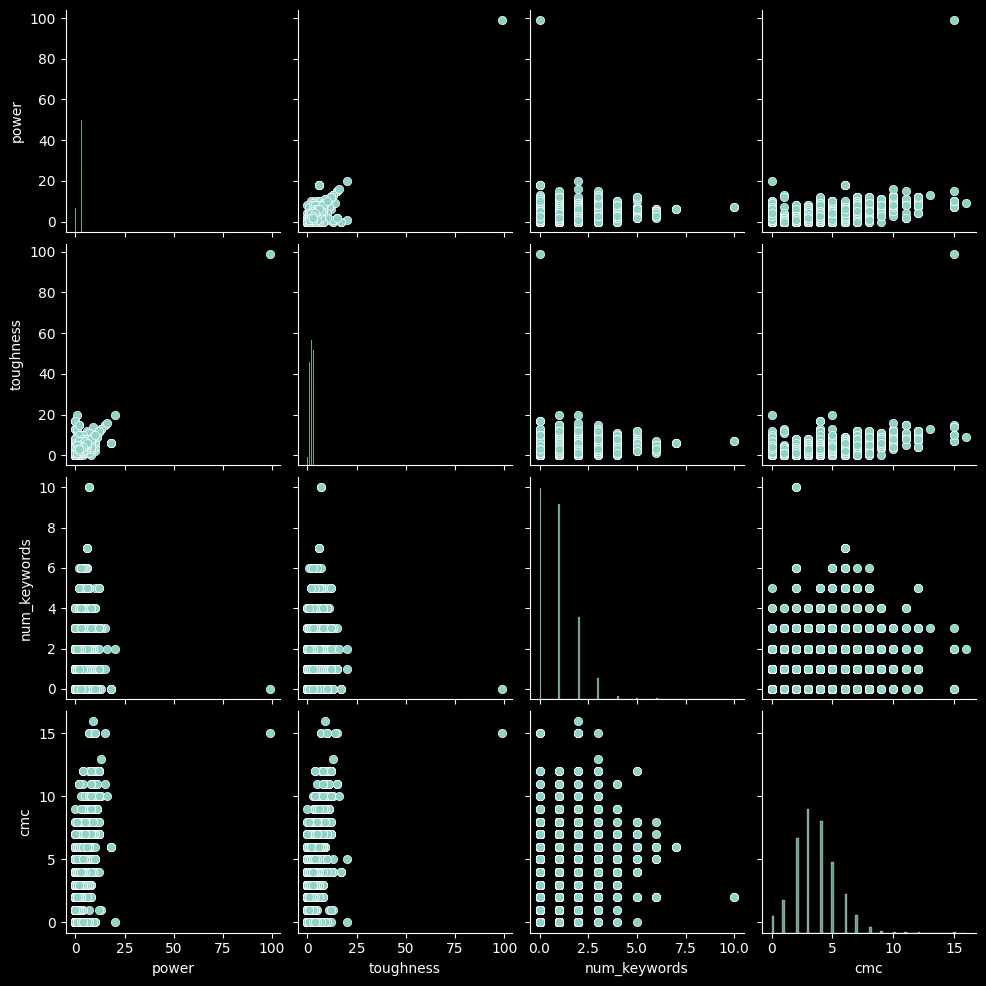

In [38]:
# Explore the data
import seaborn as sns
import matplotlib.pyplot as plt

Xy = data[["power", "toughness", "num_keywords", "cmc"]].dropna()
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]

sns.pairplot(Xy)
# plt.plot(X["power"], y, ".r", X["toughness"], y, ".b")


In [66]:
# Define the class
import numpy as np

class BasicLinearRegression():

    def __init__(self):
        self.trained = False
        self.theta = None
        self.X_mean = None
        self.X_std = None

    def normalize_features(self, X: np.ndarray[float]):
        X = np.divide((X - self.X_mean), self.X_std)
        return X

    def compute_cost(self, X: np.ndarray[float],  y: np.ndarray[float]) -> float:
        J = np.sum(
            np.square(
                (np.matmul(X, self.theta) - y)
                )
            )/(2*len(y))
        return J

    def initialize_theta(self, X: np.ndarray[float]) -> np.ndarray[float]:
        self.theta = np.random.rand(X.shape[1])

    def train(self, X: np.ndarray[float], y: np.ndarray[float], alpha: float, num_iters: int) -> list[float]:
        self.X_mean = np.mean(X)
        self.X_std = np.std(X)
        X = self.normalize_features(X)
        X = np.concatenate((np.ones((len(X), 1)), X), axis=1)

        self.initialize_theta(X)
        cost_history = [self.compute_cost(X, y)]
        for _ in range(num_iters):
            dtheta = np.zeros_like(self.theta)
            for itheta in range(len(self.theta)):
                dtheta[itheta] = alpha/len(y)*np.sum(
                    np.dot(
                        (np.matmul(X, self.theta) - y),
                        X[:, itheta]
                    )
                )
            self.theta = self.theta - dtheta
            cost_history.append(self.compute_cost(X, y))

        self.trained = True
        return (self.theta, cost_history)
    
    def predict(self, X: np.ndarray[float]):
        X = self.normalize_features(X)
        X = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        return np.matmul(X, self.theta)


Text(0, 0.5, 'Loss or Cost')

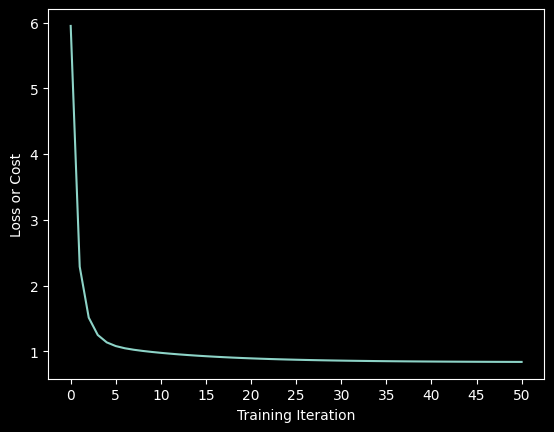

In [67]:
model = BasicLinearRegression()
num_iters = 50
alpha = 0.3
theta, loss = model.train(X.to_numpy(), y.to_numpy(), alpha=alpha, num_iters=num_iters)
plt.plot(loss)
plt.xticks(np.arange(0, num_iters+1, 5))
plt.xlabel("Training Iteration")
plt.ylabel("Loss or Cost")


In [86]:
X_model = np.array([min(X), max(X)])
y_model = model.predict(X_model)

plt.subplot(1, 3, 1)
plt.plot(X[:,0], y, ".w", X_model[:,0], y_model, "-w")

plt.subplot(1, 3, 2)
plt.plot(X[:,1], y, ".w", X_model[:,1], y_model, "-w")

plt.subplot(1, 3, 3)
plt.plot(X[:,2], y, ".w", X_model[:,2], y_model, "-w")


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U12'), dtype('<U12')) -> None

In [85]:
# X_model = np.array([X.min().to_numpy(), X.max().to_numpy()])
# y_model = model.predict(X_model)

g = sns.PairGrid(Xy.to_numpy())
g.map_offdiag(sns.regplot, x_estimator=model.predict)
# sns.pairplot(Xy)


TypeError: Data source must be a DataFrame or Mapping, not <class 'numpy.ndarray'>.